## **SwAV Pre-training**
---
---

In [1]:
!nvidia-smi

Wed Apr 21 08:48:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 455.23.05    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:86:00.0 Off |                    0 |
| N/A   59C    P0    48W / 250W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# %%capture
# !pip install self-supervised
# !pip install fastai

In [5]:
import datetime

In [1]:
from fastai.vision.all import *
torch.backends.cudnn.benchmark = True
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.vision.swav import *
import time

ModuleNotFoundError: No module named 'self_supervised'

In [6]:
bs, resize, size = 256, 92, 92

In [7]:
def get_dls(size, bs, workers=None):
    def dummy_label(o): return 0
    files = map(lambda img: f'/dataset/unlabeled/{img}', os.listdir('/dataset/unlabeled/'))
    files=list(files)
    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=1.)],[dummy_label,Categorize()]]
    
    dsets = Datasets(files, tfms=tfms,splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [8]:
dls = get_dls(resize, bs)

In [9]:
arch = "xresnet18"
encoder = create_encoder(arch, pretrained=False, n_in=3)

In [10]:
K = bs*2**4

In [12]:
model = create_swav_model(encoder)

In [13]:
aug_pipelines = get_swav_aug_pipelines(num_crops=[2,6],
                                       crop_sizes=[size,int(3/4*size)], 
                                       min_scales=[0.25,0.2],
                                       max_scales=[1.0,0.35],
                                       rotate=True, rotate_deg=10, jitter=True, bw=True, blur=False)

In [14]:
cbs=[SWAV(aug_pipelines, crop_assgn_ids=[0,1], K=K, queue_start_pct=0.5, temp=0.1)]

In [15]:
learn = Learner(dls, model, cbs=cbs)

In [16]:
prior_trained_path=None
if prior_trained_path:
    learn.load(prior_trained_path)

In [17]:
# To see image augmentations!
# b = dls.one_batch()
# learn._split(b)
# learn('before_batch')
# learn.swav.show(n=5);

In [18]:
learn.to_fp16();

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [19]:
lr,wd,epochs=1e-3,1e-2,50

In [20]:
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5,cbs=SaveModelCallback(fname=f'{arch}_best_{str(datetime.datetime.now())}'))

epoch,train_loss,valid_loss,time
0,5.145883,5.276466,08:39
1,5.172602,5.274069,08:33
2,5.124110,5.274905,08:34
3,5.145350,5.274746,08:36
4,5.098622,5.310465,08:32
5,5.098902,5.258451,08:33
6,5.122977,5.264378,08:31
7,5.105887,5.263676,08:31
8,5.129888,5.264331,08:31
9,5.110394,4.878231,08:34


In [21]:
save_name = f'swav_pretrain_epoch{epochs}_{arch}_v1'
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{arch}_encoder.pth')
torch.save(learn.model.encoder.state_dict(), f'{arch}_encoder.pth')

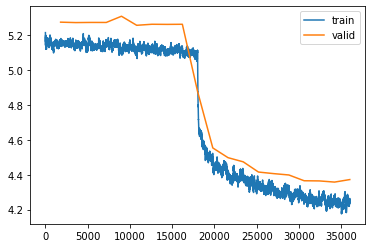

In [22]:
learn.recorder.plot_loss()